In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [ ]:
def get_padding(in_size, kernel_size, stride):
    if (in_size % stride == 0):
        padding = max(kernel_size - stride, 0)
    else:
        padding = max(kernel_size - (in_size % stride), 0)
    return (padding)    

In [ ]:
def get_temporal_feature_extractor(input_size):
  pad = get_padding(input_size, 5,  2)
  conv1 = nn.Conv3d(1, 32, kernel_size = (1, 1, 5), stride=(1, 1, 2), padding=(0, 0, 2))
  relu1 = nn.ReLU()
  pad = get_padding(input_size, 3,  2)
  conv2 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  relu2 = nn.ReLU()
  conv3 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  relu3 = nn.ReLU()
  conv4 = nn.Conv3d(32, 32, kernel_size = (1, 1, 16), stride=(1, 1, 16), padding=0)
  relu4 = nn.ReLU()
  #print("11")
  result = torch.nn.Sequential(conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4)
  #print("22")
  #print(result)
  return(result)

In [ ]:
def get_regional_feature_extractor():
  conv1 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  relu1 = nn.ReLU()
  conv2 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  relu2 = nn.ReLU()
  return(torch.nn.Sequential(conv1, relu1, conv2, relu2))

In [ ]:
class Asymmetric_feature_extractor(torch.nn.Module): 
   def __init__(self):
     super().__init__()
     self.conv = nn.Conv2d(32, 64, kernel_size = 1, stride=1 , padding='same')
     self.relu = nn.ReLU()
   def forward(self, input):
     #input(bs, h, w, nf)
     half_mat = torch.split(input, (4, 1, 4), dim = 3)
     #print(half_mat.shape)
     input_new =  half_mat[0] -  half_mat[2]
     #print(input.shape)
     output = self.conv(input_new)
     output = self.relu(output)
     #print(output.shape)
     return output

def get_asymmetric_feature_extractor():
    return (Asymmetric_feature_extractor())


In [ ]:
class EmotionNet(torch.nn.Module): 
   def __init__(self, hcanals, wcanals, nfeatures, ntimes_in_sample):
      super().__init__()
      #print("1")
      self.tfe = get_temporal_feature_extractor(ntimes_in_sample) #(bs, 1, h = 9, w = 9, s = 128) -> (bs, h = 9, w = 9, s = 1)
      #print("2")
      self.rfe = get_regional_feature_extractor() #(h = 9, w = 9, s = 32) -> (h = 9, w = 9, s = 32)
      #print("3")
      self.afe = get_asymmetric_feature_extractor()
      #print("4")
      self.flat1 = nn.Flatten(1, 3)
      self.flat2 = nn.Flatten(1, 3)
      self.input_linear_size = int(hcanals * (wcanals//2)* nfeatures * 2 + hcanals * (wcanals)* nfeatures)
      #print(self.input_linear_size)
      #print("5")
      self.fc1 = nn.Linear(self.input_linear_size, 20)
      self.relu1 = nn.ReLU()
      self.drop = nn.Dropout(0.3)
      self.fc2 = nn.Linear(20, 2)
   def forward(self, input):
      input = input.unsqueeze(1)
      #print(f"input_shape = {input.shape}")
      
      #input (bs, in_canals = 1,  h=9, w=9, s=128)
      output_tfe = self.tfe(input)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      #output_tfe (bs, in_canals = 32,  h=9, w=9, s=1)
      output_tfe = output_tfe.squeeze(4)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      
      #output_rfe (bs, canals = 32,  h=9, w=9)
      output_rfe = self.rfe(output_tfe)
      #print(f"output_rfe.shape = {output_rfe.shape}")
      output_afe = self.afe(output_tfe)

      output_rfe = output_rfe.permute(0, 2, 3, 1) 
      #output_rfe (bs, h=9, w=9, 32)
      output_afe = output_afe.permute(0, 2, 3, 1) 
      #output_afe (bs, h=9, w=4, 64)
      #print(f"output_afe.shape = {output_afe.shape}")
      #output_rfe (bs, canals = 64,  h=4, w=9)
      output_rfe_flatten = self.flat1(output_rfe)
      #print(f"output_rfe_flatten.shape = {output_rfe_flatten.shape}")
      output_afe_flatten = self.flat2(output_afe)
      #print(f"output_afe_flatten.shape = {output_afe_flatten.shape}")
      output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      #print(f"output1.shape = {output1.shape}")
      output1_relu = self.relu1(output1)
      #print(f"output1_relu.shape = {output1_relu.shape}")
      output2 = self.fc2(output1_relu)
      #print(f"output2.shape = {output2.shape}")
      return output2


In [ ]:
LEN_RECORD_IN_SECONDS = 60
NVIDEOS = 40
HCANALS = 9
WCANALS = 9
NTIMES_IN_SAMPLE = 128
NTIMES_IN_SEC = 128
NCANALS = 32
NFEATURES = 32
electrode_matrix = {}
electrode_matrix['FP1'] = [0, 3]
electrode_matrix['FP2'] = [0, 5]
electrode_matrix['AF3'] = [1, 3]
electrode_matrix['AF4'] = [1, 5]
electrode_matrix['F7']  = [2, 0]
electrode_matrix['F3']  = [2, 2]
electrode_matrix['FZ']  = [2, 4]
electrode_matrix['F4']  = [2, 6]
electrode_matrix['F8']  = [2, 8]
electrode_matrix['FC5']  = [3, 1]
electrode_matrix['FC1']  = [3, 3]
electrode_matrix['FC2']  = [3, 5]
electrode_matrix['FC6']  = [3, 7]
electrode_matrix['T7']  = [4, 0]
electrode_matrix['C3']  = [4, 2]
electrode_matrix['CZ']  = [4, 4]
electrode_matrix['C4']  = [4, 6]
electrode_matrix['T8']  = [4, 8]
electrode_matrix['CP5']  = [5, 1]
electrode_matrix['CP1']  = [5, 3]
electrode_matrix['CP2']  = [5, 5]
electrode_matrix['CP6']  = [5, 7]
electrode_matrix['P7']  = [6, 0]
electrode_matrix['P3']  = [6, 2]
electrode_matrix['PZ']  = [6, 4]
electrode_matrix['P4']  = [6, 6]
electrode_matrix['P8']  = [6, 8]
electrode_matrix['PO3'] = [7, 3]
electrode_matrix['PO4'] = [7, 5]
electrode_matrix['O1'] = [8, 3]
electrode_matrix['OZ'] = [8, 4]
electrode_matrix['O2'] = [8, 5]

list_electrodes = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'OZ',	'PZ',	'FP2',	'AF4', 'FZ', 'F4', 'F8', 'FC6',	'FC2',	'CZ', 'C4', 'T8', 'CP6',	'CP2',	'P4', 	'P8',	'PO4',	'O2']
data_dir = './data_preprocessed_python'
TRAIN_SIZE = 0.9
THRESHOLD = 5

In [ ]:
type_emotion = 0

In [ ]:
import glob
import pickle
from sklearn.preprocessing import MinMaxScaler

data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))
data_raw = []
for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    #data_raw.append(raw_data['data'][:, :, :])
    # data_raw[-1][0, :32, 0]
    # print(data_raw[-1][:, :31, :].min())
    # print(data_raw[-1][:, :31, :].max())
    # scaler = MinMaxScaler()
    # for i in range(40):
    #     #scaler.fit(data[-1][i])
    #     scaler = MinMaxScaler()
    #     data[-1][i] = scaler.fit_transform(data[-1][i])
    #     print(data_raw[-1][i])
    #     print(data[-1][i])
    #     break
    labels.append(raw_data['labels'])
    #break



In [ ]:
# import matplotlib
# from matplotlib import pyplot as plt
# fig, axes = plt.subplots(1, 2, figsize = (30, 5))
# axes[0].plot(data[0][0][0])
# axes[1].plot(data_raw[0][0][0])

# plt.subplot(1, 5, 2)
# plt.plot(data[0][0][1])


# plt.subplot(1, 5, 3)
# plt.plot(data[0][0][2])

# plt.subplot(1, 5, 4)
# plt.plot(data[0][0][3])



In [ ]:
import glob
import pickle
from collections import Counter

class EmotionDataset(Dataset):
    def __init__ (self, data_dir, type, ind, data, labels):
       self.data = []
       self.labels = []
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       #data_dir = './data_preprocessed_python'
       #files = glob.glob(os.path.join(data_dir, "*.dat"))[0:1]
       self.type = type
       #split = int(LEN_RECORD_IN_SECONDS)# *  TRAIN_SIZE)
       self.ind = ind
       self.len_files = []
       for s in range(len(data)):
            #print(file_data)
            #raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
            #print(raw_data['data'].shape)
            #labels = raw_data['labels']
            self.data.append(data[s][ind, :, 3 * NTIMES_IN_SEC :LEN_RECORD_IN_SECONDS * NTIMES_IN_SEC + 3 * NTIMES_IN_SEC])
            self.len_files.append(len(ind) *  LEN_RECORD_IN_SECONDS - 1)
            self.len_record = LEN_RECORD_IN_SECONDS
            labels_bin_sub = (labels[s] >= THRESHOLD)
            self.labels.append(labels_bin_sub[ind])          
            for i in range(4):
              self.cnt[i].update(list(self.labels[-1][:, i]))    

            
       self.len_cumsum = np.cumsum(self.len_files)     
       print(self.data[0].shape)
       print(self.labels[0].shape)



    def __len__(self):
        result =  sum(self.len_files) - 10
        return result

    def get_index_record(self, item):
      for i_file in range(len(self.len_cumsum)):
         #print(item, self.len_cumsum[i_file])
         if (item > self.len_cumsum[i_file]):
            continue
         else:
            break
      if i_file == 0:
         index_in_file = item
      else:
         index_in_file = item  - self.len_cumsum[i_file - 1]
      nvideo = index_in_file//(self.len_record)# * LEN_RECORD_IN_SECONDS *  NTIMES_IN_SEC)
      nsec = (index_in_file - nvideo * self.len_record) # *   NTIMES_IN_SEC)

      return i_file, index_in_file, nvideo, nsec

    def __getitem__(self, item):
      sample = {}
      #print(item)
      i_file, index_in_file, nvideo, nsec = self.get_index_record(item)
      #print(i_file, nvideo, nsec )
      sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
      sample_from_one_canals = []
      for i_canal in range(NCANALS):
        sample_from_one_canal = self.data[i_file][nvideo, i_canal, nsec * 128 : nsec * 128 + 128]
        sample_from_one_canals.append(sample_from_one_canal)
        #print(sample_from_one_canal.shape)
      sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      sample_from_one_canals = scipy.stats.zscore(sample_from_one_canals, axis = None)
      for i_canal in range(NCANALS):
          sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
      #for i in range(NTIMES_IN_SAMPLE): 
      #    sample['data'][:, :, i] = scipy.stats.zscore(sample['data'][:, :, i])
      sample['data'] = torch.FloatTensor(sample['data'])
      sample['labels']  = torch.LongTensor(self.labels[i_file][nvideo])
      
      return sample


In [ ]:
def get_model():
  model = EmotionNet(HCANALS, WCANALS, NFEATURES, NTIMES_IN_SAMPLE).to(device)
  return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model()
# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             nn.init.constant_(param.data, 0)
            
# model.apply(init_weights)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

EmotionNet(
  (tfe): Sequential(
    (0): Conv3d(1, 32, kernel_size=(1, 1, 5), stride=(1, 1, 2), padding=(0, 0, 2))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(1, 1, 3), stride=(1, 1, 2), padding=(0, 0, 1))
    (3): ReLU()
    (4): Conv3d(32, 32, kernel_size=(1, 1, 3), stride=(1, 1, 2), padding=(0, 0, 1))
    (5): ReLU()
    (6): Conv3d(32, 32, kernel_size=(1, 1, 16), stride=(1, 1, 16))
    (7): ReLU()
  )
  (rfe): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (afe): Asymmetric_feature_extractor(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (relu): ReLU()
  )
  (flat1): Flatten(start_dim=1, end_dim=3)
  (flat2): Flatten(start_dim=1, end_dim=3)
  (fc1): Linear(in_features=4896, out_features=20, bias=True)
  (relu1): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=20, ou

In [ ]:
# files = glob.glob(os.path.join(data_dir, "*.dat"))
# files.sort()
# files = np.asarray(files)
# nfiles = len(files)
# koeff1 = 0.99
# # koeff2 = 0.05
# ind_train = random.sample(range(nfiles), int(nfiles * koeff1))
# ind_val = list(set(range(nfiles)) - set(ind_train))
# #ind_val = random.sample(ind, int(len(ind) * koeff2))
# # ind_test = list(set(ind) - set(ind_val))

In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 100
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="runs/segmentation_baseline"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()    

In [ ]:
# from sklearn.model_selection import StratifiedKFold 
# from sklearn.metrics import f1_score, accuracy_score
# k  = 8
# labels_bin = []
# for i in range(32):
#   temp = labels[i] > 4.5
#   #print(labels[i])
#   #print(temp)
#   labels_bin.append(temp)
# X = np.arange(40)
# y = np.array(labels_bin[0][:, type_emotion])
# skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
# balanced_split = skf.split(X, y)
# for ind_train, ind_test in  balanced_split:
#     print(ind_train, ind_test)
#     print(sum(labels_bin[0][ind_train, type_emotion]))
#     print(sum(labels_bin[0][ind_test, type_emotion]))
#     break

In [ ]:

# train_dataset = EmotionDataset(args.data_dir, 'train', ind_train, data, labels)

# class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
# weights_samples =  [0] * train_dataset.__len__()
# for i in range(train_dataset.__len__()):
#     i_file, index_in_file, nvideo, nsec = train_dataset.get_index_record(i)
#     #print(train_dataset.labels[i_file][nvideo])
#     weights_samples[i] = class_weights_all[int(train_dataset.labels[i_file][nvideo, 0])]

# weighted_sampler = WeightedRandomSampler(
#     weights=weights_samples,
#     num_samples=len(weights_samples),
#     replacement=True
# )
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)


# val_dataset = EmotionDataset(args.data_dir, 'val', ind_test, data, labels)
# val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
# train_dataset = EmotionDataset(files[ind_train])
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=True, drop_last=True)


# val_dataset = EmotionDataset(files[ind_val])
# val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
criterion = nn.CrossEntropyLoss(reduce = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# print(train_dataset.cnt)
# print(val_dataset.cnt)
# print(files[ind_train])
# print(files[ind_val])

In [ ]:
def train(model, loader, criterion, optimizer, device, type_emotion, batch = None):
    model.train()
    train_loss = []
    inputs = []
   
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for batch in tqdm(loader, total=len(loader), desc="training...", position=0 , leave = True):

            optimizer.zero_grad()
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]

            #print(trg.sum())
            #print(trg.shape)
            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()

            #usual cross entropy
            #output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            #trg1 = trg[:, 1:].reshape(-1)
            loss = criterion(levels_pred, trg) 

            #print("after")
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            #break
    return np.mean(train_loss)#, mid_outputs


In [ ]:
def evaluate(model, loader, criterion, device, type_emotion):
    
    model.eval()
    epoch_loss = 0
    history = []
  
    with torch.no_grad():
    
        for s, batch in enumerate(tqdm(loader, total=len(loader), desc="validating...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]



            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()

            
            loss = criterion(levels_pred, trg) 

            epoch_loss += loss.item() 
        
    return epoch_loss / s

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def calculate_predictions(model, loader, type_emotion):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    with torch.no_grad():

        for i, batch in enumerate(tqdm(loader, total=len(loader), desc="predicting...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]
            
           

            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            #print(levels_pred.shape)
            trg_pred = levels_pred.argmax(1)
            
            real.extend(trg)
            pred.extend(trg_pred) 

            
        #print(accuracy_score(real, pred)) 
        #print(confusion_matrix(real, pred))  
        #print(classification_report(real, pred))   
    return (accuracy_score(real, pred), f1_score(real, pred, average = 'macro'))

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
k  = 8
labels_bin = []
for i in range(32):
  temp = labels[i] > 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
X = np.arange(40)
y = np.array(labels_bin[0][:, type_emotion])
skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
balanced_split = skf.split(X, y)
for ind_train, ind_test in  balanced_split:
    print(ind_train, ind_test)
    print(sum(labels_bin[0][ind_train, type_emotion]))
    print(sum(labels_bin[0][ind_test, type_emotion]))
    break

[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 18 20 21 22 23 24 25 26
 28 30 31 32 33 34 35 36 37 38 39] [ 4 17 19 27 29]
17
3


In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
k  = 5
labels_bin = []
for i in range(32):
  temp = labels[i] > 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
X = np.arange(40)
y = np.array(labels_bin[0][:, type_emotion])
skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
balanced_split = skf.split(X, y)
for fold,  (ind_train, ind_test) in  enumerate(balanced_split):
    print(ind_train, ind_test)
    print(sum(labels_bin[0][ind_train, type_emotion]))
    print(sum(labels_bin[0][ind_test, type_emotion]))

    train_dataset = EmotionDataset(args.data_dir, 'train', ind_train, data, labels)

    class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
    weights_samples =  [0] * train_dataset.__len__()
    for i in range(train_dataset.__len__()):
        i_file, index_in_file, nvideo, nsec = train_dataset.get_index_record(i)
        #print(train_dataset.labels[i_file][nvideo])
        weights_samples[i] = class_weights_all[int(train_dataset.labels[i_file][nvideo, 0])]

    weighted_sampler = WeightedRandomSampler(
        weights=weights_samples,
        num_samples=len(weights_samples),
        replacement=True
    )
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                  pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)


    val_dataset = EmotionDataset(args.data_dir, 'val', ind_test, data, labels)
    val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                  pin_memory=True, shuffle=False, drop_last=False)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = get_model()
   
    model.apply(initialize_weights) 

    criterion = nn.CrossEntropyLoss(reduce = 'mean')#torch.nn.MSELoss()
    #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)

    args.epochs = 10

    #criterion =  fnn.mse_loss
    train_loss_min = 10000
    val_loss_min = 10000
    #batch = next(iter(train_dataloader))
    for epoch in range(args.epochs):
        #logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")
        
        train_loss = train(model, train_dataloader, criterion, optimizer ,device)
        #if epoch % 500 == 0:
        print(train_loss)

        # if (train_loss < train_loss_min):
        #     train_loss_min      = train_loss
        #     torch.save({
        #                     'model_state_dict': model.state_dict(),
        #                     'optimizer_state_dict': optimizer.state_dict(),
        #                   },
        #                   os.path.join("/content/drive/MyDrive/MADE/Project/RACNN_models/", "train.tgz")
        #         )  

        val_loss = evaluate(model, val_dataloader, criterion, device)
        # #break
        print(val_loss)
        #break

        # #calculate_predictions(model, val_dataloader)
        if (val_loss < val_loss_min):
            val_loss_min      = val_loss
            torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join("/content/drive/MyDrive/MADE/Project/RACNN_models/", f"val_{type_emotion}_{fold}.tgz"))

[ 0  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 19 20 23 24 25 26 27 29
 30 31 32 33 34 37 38 39] [ 1  9 18 21 22 28 35 36]
16
4
(32, 40, 7680)
(32, 4)
(8, 40, 7680)
(8, 4)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6834580939123331


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6819956086429895


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6625343544642649


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6756328648211909


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6465425680939952


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6863275625152525


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6333262027768481


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.659790392697247


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6262504784162437


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6691028785471823


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6186094094450673


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.674219625058517


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.607630921032456


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7005185978669747


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5983611164435283


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7185230477183473


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5907173440662528


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7438626053676106


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5817080869371312


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.715889950788099
[ 0  1  2  4  6  7  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28
 30 31 33 34 35 36 37 38] [ 3  5  8 11 25 29 32 39]
16
4
(32, 40, 7680)
(32, 4)
(8, 40, 7680)
(8, 4)


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6902813019799174


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6944758313543656


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.672322877176823


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6775393049701367


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6561545862848179


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6724485818759288


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6453162140013926


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7042662173120025


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6386941731656745


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6891202843851514


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6297021275826807


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7141239658679838


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6188464765642051


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7239219094413558


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6085099942532488


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7416316379908643


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6028885770388568


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7262653102672177


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5966603219217422


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7427773482464497
[ 1  2  3  4  5  6  7  8  9 10 11 12 14 18 19 21 22 23 24 25 26 27 28 29
 31 32 33 34 35 36 37 39] [ 0 13 15 16 17 20 30 38]
16
4
(32, 40, 7680)
(32, 4)
(8, 40, 7680)
(8, 4)


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6904940086904591


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6956911605168012


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6838601045857441


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6942582371967291


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6778035169713454


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6911541190412309


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6648556629946337


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6729475789599948


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6530748886735366


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6728879215280994


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6463647125012334


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6748755465145984


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6371429668554085


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6712982133517857


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.628841584308307


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6781393040239422


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6229408508801733


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6808473724944919


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6157124568548716


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6861840348228131
[ 0  1  3  4  5  6  8  9 10 11 12 13 15 16 17 18 19 20 21 22 24 25 28 29
 30 31 32 35 36 37 38 39] [ 2  7 14 23 26 27 33 34]
16
4
(32, 40, 7680)
(32, 4)
(8, 40, 7680)
(8, 4)


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.682504999307007


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6955580839923784


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.657923047635917


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.738674101584098


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6423330051280546


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.717826676719329


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6331050756704943


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7564306167605656


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6249442930906087


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7277150144374448


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.615081950268582


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7433046342111101


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6077426698235081


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7718196294081756


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6026046969373308


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7663116785241109


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5951606906452148


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7670932260214114


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5858551876385488


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.78747834596369
[ 0  1  2  3  5  7  8  9 11 13 14 15 16 17 18 20 21 22 23 25 26 27 28 29
 30 32 33 34 35 36 38 39] [ 4  6 10 12 19 24 31 37]
16
4
(32, 40, 7680)
(32, 4)
(8, 40, 7680)
(8, 4)


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6836050830501911


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7004210428864348


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6705915146122944


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6870893327628865


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6568101460743107


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.697994612498221


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6463232276684697


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6856447910171708


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.633305399102838


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6639057259544049


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6201629958572823


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6857269406318665


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6097236105512833


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6648797514586667


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.594644167294899


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6645401284780378


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5861370401125747


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6745461590734183


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.5732903699793201


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6896162526864632


In [ ]:
model_state  = torch.load(os.path.join("/content/drive/MyDrive/MADE/Project/RACNN_models/", f"val.tgz"))
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
calculate_predictions(model, val_dataloader)

In [ ]:
def get_batch()

In [ ]:

ind_tests = [[ 1,  9, 18, 21, 22, 28, 35, 36],[ 3,  5,  8, 11, 25, 29, 32, 39],[ 0, 13, 15, 16, 17, 20, 30, 38],[ 2,  7 ,14, 23, 26, 27, 33, 34],[ 4,  6, 10, 12, 19, 24, 31, 37]]
accs_result = []
f1_result = []
for sub in range(32):
  accs_all = []
  f1_all = []
  for fold in range(len(ind_tests)):
      model_state  = torch.load(os.path.join("/content/drive/MyDrive/MADE/Project/RACNN_models/", f"val_{type_emotion}_{fold}.tgz"))
      #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
      model.load_state_dict(model_state['model_state_dict'])
      val_dataset_sub = EmotionDataset(args.data_dir, 'val', ind_tests[fold], data[sub:sub + 1], labels[sub : sub + 1])
      val_dataloader_sub = DataLoader(val_dataset_sub, batch_size=args.batch_size, num_workers=1,
                                  pin_memory=True, shuffle=False, drop_last=False)
       
      #print(val_datar_sub.cnt)
      acc, f1 = calculate_predictions(model, val_dataloader_sub)
      accs_all.append(acc)
      f1_all.append(f1)
  print(np.mean(accs_all))    
  print(np.mean(f1_all))    
  accs_result.append(np.mean(accs_all))
  f1_result.append(np.mean(f1_all))
print(np.mean(accs_result))    
print(np.mean(f1_result))    




(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.4690831556503198
0.40537980768365267
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.625586353944563
0.47537950561062503
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5910447761194029
0.5505384184664063
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5658848614072495
0.427166355328365
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5889125799573561
0.4504195822430249
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7347547974413647
0.4440875137105752
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6686567164179105
0.4710417223055461
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5680170575692963
0.5123478577800157
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5620469083155651
0.5254680702934541
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7275053304904052
0.692755846466959
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5501066098081024
0.39638884804244945
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5547974413646056
0.4786660202757688
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.666950959488273
0.624937224533246
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6174840085287847
0.5844624087446653
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6993603411513859
0.6736506037129391
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6196162046908316
0.5028894723734023
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.4899786780383796
0.4268303580918305
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.68272921108742
0.6457844832528011
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.4776119402985075
0.4044868131006747
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6153518123667377
0.5378664876124365
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.38976545842217486
0.31936873473412525
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5279317697228144
0.4507595269830123
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6797441364605544
0.5502838525223815
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.479317697228145
0.39589075675534363
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5398720682302771
0.4711622233897055
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6115138592750534
0.40736124654159733
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7275053304904051
0.488821413413606
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.612366737739872
0.423745568468187
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5172707889125799
0.4711275780136222
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6976545842217484
0.4814313540017364
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5727078891257996
0.4475294222808247
(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5240938166311301
0.4276786646490665
0.5923507462686567
0.4864283669181889


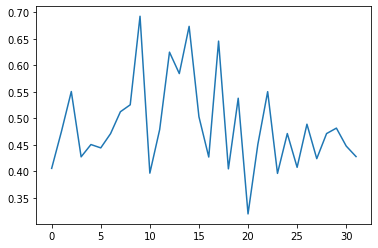

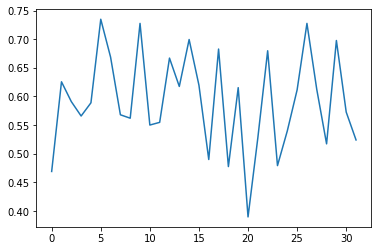

In [ ]:
from matplotlib import pyplot as plt
plt.plot(f1_result)
plt.show()
plt.plot(accs_result) 
plt.show()